In [1]:
# 필요한 라이브러리를 임포트합니다.
import numpy as np
import pandas as pd
import os
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.calibration import calibration_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# GPU 로그 출력을 활성화합니다.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 기본값은 0입니다. 2는 INFO 수준 이상의 로그만 출력합니다.

# TensorFlow와 GPU 확인 및 설정
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# GPU 사용 강제 설정
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    device_name = tf.config.list_physical_devices('GPU')[0].name
    print("Using GPU:", device_name)
else:
    device_name = '/cpu:0'
    print("Using CPU")

# GPU 사용 강제 설정 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 할당 제한 해제
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# 파일 경로 설정
hackaton_folder = './'  # 현재 폴더 내 hackaton 폴더
train_csv_path = os.path.join(hackaton_folder, 'train.csv')
test_csv_path = os.path.join(hackaton_folder, 'test.csv')
sample_submission_path = os.path.join(hackaton_folder, 'sample_submission.csv')
train_audio_folder = os.path.join(hackaton_folder, '')
test_audio_folder = os.path.join(hackaton_folder, '')
unlabeled_audio_folder = os.path.join(hackaton_folder, '')

# train.csv 파일을 로드합니다.
df = pd.read_csv(train_csv_path)
df


TensorFlow version: 2.16.2
Num GPUs Available:  0
Using CPU


,id,path,label
0,RUNQPNJF,./train/RUNQPNJF.ogg,real
1,JFAWUOGJ,./train/JFAWUOGJ.ogg,fake
2,RDKEKEVX,./train/RDKEKEVX.ogg,real
3,QYHJDOFK,./train/QYHJDOFK.ogg,real
4,RSPQNHAO,./train/RSPQNHAO.ogg,real
...,...,...,...
55433,NJGPMAJL,./train/NJGPMAJL.ogg,real
55434,SZXIACUZ,./train/SZXIACUZ.ogg,fake
55435,PXLBTGRH,./train/PXLBTGRH.ogg,fake
55436,CGGQGPOQ,./train/CGGQGPOQ.ogg,fake


In [2]:
# Label 인코딩
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

df['class'] = label_encoder(df['label'])
df['class']


label ['fake' 'real']


0        1
1        0
2        1
3        1
4        1
        ..
55433    1
55434    0
55435    0
55436    0
55437    0
Name: class, Length: 55438, dtype: int32

In [14]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=32000)
    
    # 신호 길이에 따라 n_fft 조정
    n_fft = 1024
    if len(y) < n_fft:
        padding = n_fft - len(y)
        y = np.pad(y, (0, padding), 'constant')

    hop_length = max(1, n_fft // 4)
    
    # Extract various features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    # Mean and standard deviation of the features
    mfcc = np.concatenate((np.mean(mfcc.T, axis=0), np.std(mfcc.T, axis=0)))
    chroma = np.concatenate((np.mean(chroma.T, axis=0), np.std(chroma.T, axis=0)))
    mel = np.concatenate((np.mean(mel.T, axis=0), np.std(mel.T, axis=0)))
    contrast = np.concatenate((np.mean(contrast.T, axis=0), np.std(contrast.T, axis=0)))
    tonnetz = np.concatenate((np.mean(tonnetz.T, axis=0), np.std(tonnetz.T, axis=0)))
    zcr = np.concatenate((np.mean(zcr.T, axis=0), np.std(zcr.T, axis=0)))
    rolloff = np.concatenate((np.mean(rolloff.T, axis=0), np.std(rolloff.T, axis=0)))
    
    return np.concatenate((mfcc, chroma, mel, contrast, tonnetz, zcr, rolloff))

def get_audio_features(df, folder, train_mode=True):
    features = []
    labels = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        file_path = os.path.join(folder, row['path'])
        if os.path.isfile(file_path):
            feature = extract_features(file_path)
            features.append(feature)
            if train_mode:
                label = row['label']
                labels.append(label)
        else:
            print(f"File not found: {file_path}")
    if train_mode:
        return features, labels
    return features

# Train 데이터에서 특징 추출
train_features, train_labels = get_audio_features(df, train_audio_folder, True)

# 데이터가 비어 있는지 확인
if not train_features or not train_labels:
    raise ValueError("No features or labels extracted from the training data. Check the file paths and data extraction process.")

# Train 데이터를 DataFrame으로 변환
train_feature_df = pd.DataFrame({'features': train_features, 'class': train_labels})
train_feature_df


  2%|▏         | 955/55438 [05:08<6:47:47,  2.23it/s]c:\Users\moon0\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=620
  warnings.warn(
  2%|▏         | 960/55438 [05:10<5:43:41,  2.64it/s]c:\Users\moon0\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=538
  warnings.warn(
  2%|▏         | 965/55438 [05:12<5:02:31,  3.00it/s]c:\Users\moon0\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=601
  warnings.warn(
  2%|▏         | 973/55438 [05:15<6:07:58,  2.47it/s]c:\Users\moon0\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=354
  warnings.warn(
  2%|▏         | 979/55438 [05:17<6:29:33,  2.33it/s]c:\Users\moon0\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too

In [4]:
# X와 y 데이터 준비
X = np.array(train_feature_df['features'].tolist())
y = np.array(train_feature_df['class'].tolist())


In [5]:
X


array([[-269.6044   ,  150.32973  ,  -30.714954 , ...,    4.557727 ,
           8.702893 ,  -10.020415 ],
       [-218.37141  ,  204.3821   ,  -27.344152 , ...,   -8.324829 ,
          -6.8380127,   -5.96884  ],
       [-321.7425   ,  112.8547   ,  -15.554125 , ...,    0.7927159,
          -5.9727464,  -15.064149 ],
       ...,
       [-275.46686  ,  152.44534  ,  -48.93879  , ...,  -13.386176 ,
         -14.170386 ,  -12.651383 ],
       [-304.57095  ,  169.80167  ,   27.61575  , ...,   -5.874283 ,
         -13.82838  ,   -9.7204075],
       [-311.07114  ,  145.67433  ,  -16.795443 , ...,    1.6806172,
          -5.4600234,  -14.144358 ]], dtype=float32)

In [6]:
y


array([1, 0, 1, ..., 0, 0, 0])

In [7]:
# 데이터 불균형 해결
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
y_resampled = to_categorical(y_resampled)


In [8]:
X_resampled


array([[-269.6044    ,  150.32973   ,  -30.714954  , ...,    4.557727  ,
           8.702893  ,  -10.020415  ],
       [-218.37141   ,  204.3821    ,  -27.344152  , ...,   -8.324829  ,
          -6.8380127 ,   -5.96884   ],
       [-321.7425    ,  112.8547    ,  -15.554125  , ...,    0.7927159 ,
          -5.9727464 ,  -15.064149  ],
       ...,
       [-312.55347   ,  110.53444   ,  -25.910912  , ...,   -0.85384136,
         -13.257268  ,  -14.019656  ],
       [-224.44296   ,  190.88232   ,  -41.765774  , ...,    0.751199  ,
           7.497552  ,   -9.2184    ],
       [-268.42984   ,  164.32614   ,  -22.25772   , ...,  -14.123548  ,
           1.0690728 ,  -18.85133   ]], dtype=float32)

In [9]:
y_resampled


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

TensorFlow version: 2.16.2
Num GPUs Available:  0
Using CPU
label ['fake' 'real']


100%|██████████| 55438/55438 [13:49<00:00, 66.80it/s] 
c:\Users\moon0\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,530 (400.51 KB)

 Trainable params: 102,530 (400.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5355 - loss: 4.5524 - val_accuracy: 0.7038 - val_loss: 0.6190
Epoch 2/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6567 - loss: 0.6316 - val_accuracy: 0.8163 - val_loss: 0.4550
Epoch 3/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7772 - loss: 0.4813 - val_accuracy: 0.8554 - val_loss: 0.3460
Epoch 4/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8266 - loss: 0.3955 - val_accuracy: 0.8852 - val_loss: 0.2929
Epoch 5/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8508 - loss: 0.3460 - val_accuracy: 0.8920 - val_loss: 0.2574
Epoch 6/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8692 - loss: 0.3119 - val_accuracy: 0.8932 - val_loss: 0.2569
Epoch 7/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8802 - loss: 0.2838 - val_accuracy: 0.9067 - val_loss: 0.2315
Epoch 8/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8845 - loss: 0.2744 - val_accuracy: 0.

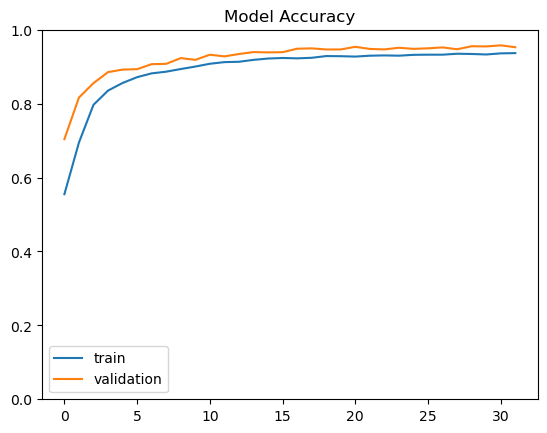

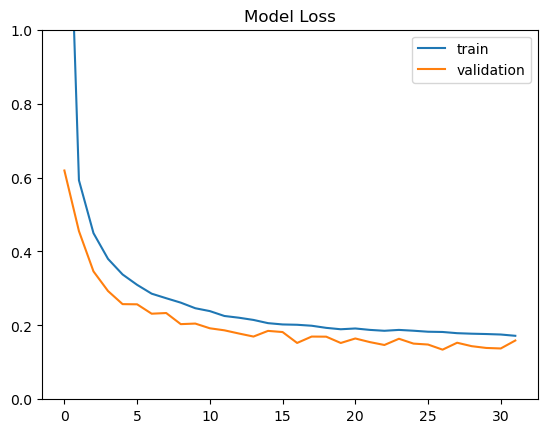

100%|██████████| 50000/50000 [17:16<00:00, 48.25it/s]


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


ValueError: The columns of the answer and submission dataframes do not match.

In [2]:
# Train/Validation 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 모델 구성
model = Sequential()
model.add(Dense(256, input_shape=(13,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))  # fake와 real 두 개의 클래스를 예측
model.add(Activation('softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 요약
model.summary()

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=50, callbacks=[early_stopping])

# Validation 데이터 평가
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# 학습 곡선 시각화
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# 평가 함수 정의
def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece

def auc_brier_ece(answer_df, submission_df):
    # Check for missing values in submission_df
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")

    # Check if the number and names of columns are the same in both dataframes
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")

    # 이진 클래스를 one-hot 인코딩으로 변환
    answer_df = pd.get_dummies(answer_df.iloc[:, 0])
    answer_df.columns = ['fake', 'real']

    # Calculate AUC for each class
    auc_scores = []
    for column in answer_df.columns:
        y_true = answer_df[column]
        y_scores = submission_df[column]
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)

    # Calculate mean AUC
    mean_auc = np.mean(auc_scores)

    brier_scores = []
    ece_scores = []

    # Calculate Brier Score and ECE for each class
    for column in answer_df.columns:
        y_true = answer_df[column].values
        y_prob = submission_df[column].values

        # Brier Score
        brier = mean_squared_error(y_true, y_prob)
        brier_scores.append(brier)

        # ECE
        ece = expected_calibration_error(y_true, y_prob)
        ece_scores.append(ece)

    # Calculate mean Brier Score and mean ECE
    mean_brier = np.mean(brier_scores)
    mean_ece = np.mean(ece_scores)

    # Calculate combined score
    combined_score = 0.5 * (1 - mean_auc) + 0.25 * mean_brier + 0.25 * mean_ece

    return combined_score

# 테스트 데이터 예측
test_df = pd.read_csv(test_csv_path)
test_mfcc = get_mfcc_feature(test_df, test_audio_folder, False)
test_mfcc = np.array(test_mfcc)

# 모델 예측
predictions = model.predict(test_mfcc)

# 제출 파일 생성
submit = pd.read_csv(sample_submission_path)
submit['fake'] = predictions[:, 0]
submit['real'] = predictions[:, 1]
submit.to_csv('./sg_submit2.csv', index=False)
submit.head()

# 최종 모델의 성능 평가
# Validation 데이터로 성능 평가
val_preds = model.predict(X_val)
val_preds_df = pd.DataFrame(val_preds, columns=['fake', 'real'])

# y_val을 다시 클래스로 변환
val_true_classes = np.argmax(y_val, axis=1)
val_true_df = pd.DataFrame(val_true_classes, columns=['true_class'])

# 각 클래스에 대해 AUC, Brier Score, ECE 계산
combined_score_val = auc_brier_ece(val_true_df, val_preds_df)
print(f'Combined Score on Validation Data: {combined_score_val:.5f}')

def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

# 테스트 예측
test_real = os.path.join(hackaton_folder, 'unlabeled_data/ABJGMLHQ.ogg')
test_fake = os.path.join(hackaton_folder, 'unlabeled_data/ZIKAHDQO.ogg')

detect_fake(test_real)
detect_fake(test_fake)
